In [1]:
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

## データ読み込み
各カラムの意味は下記

- PassengerID : 乗客ID
- Survived : 生存フラグ(0 => 死亡, 1 => 生存)
- Pclass : チケットクラス(1 => 上位, 2 => 中間, 3 => 下位)
- Name : 乗客名
- Sex : 性別
- Age : 年齢 欠損値 177
- SibSp : 兄弟、配偶者の数
- Parch : 親、子供の数
- Ticket : チケット番号
- Fare : 料金
- Cabin : 客室番号 欠損値 608
- Embarked : 出港地(C => Cherbourg, Q => Queenstown, S => Southampton) 欠損値 2

In [2]:
df = pd.read_csv('../dataset/row/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 欠損値確認

In [5]:
test_data = pd.read_csv('../dataset/row/test.csv')
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 特徴量ごとのプロファイルを確認

In [6]:
titnic_profile = pandas_profiling.ProfileReport(df, minimal=True)
titnic_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Survivedと他変数の関係

- 女性は生存率が高い
- Pclassが高い(1が最高で、3が最低)ほど生存率が高い
- 家族がいないほうが生存率が高い => 家族の有無や家族数(SibSp + Parch)を特徴量に加えるとよい？

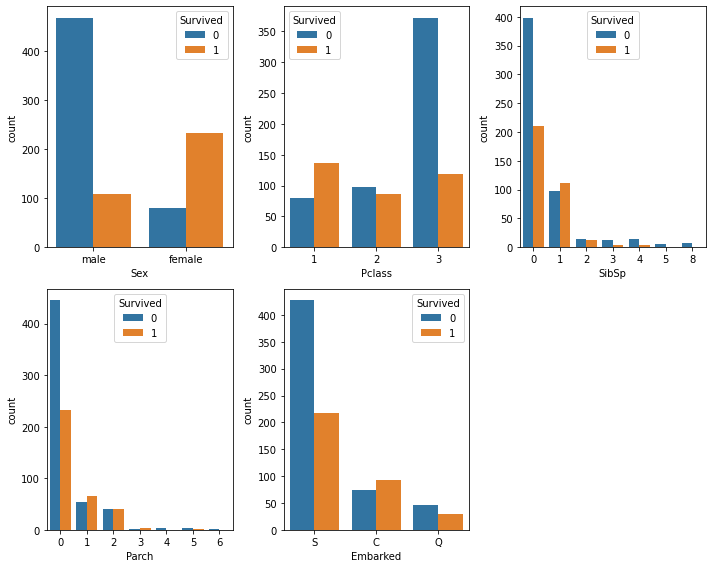

In [19]:
compare_targets = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10, 8))
for ax, compare_target in zip(axes.flatten(), compare_targets):
    sns.countplot(x=compare_target, hue='Survived', ax=ax, data=df)
axes.flatten()[-1].axis('off')
fig.tight_layout()

- 「Pclass=1 かつ male」、「Pclass=3かつfemale」が分別の難易度が高い
- 他の組み合わせは比較的分別しやすい

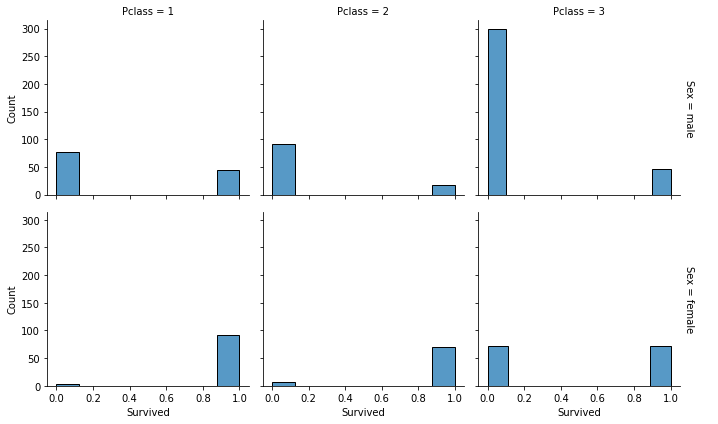

In [4]:
g = sns.FacetGrid(df, row='Sex', col='Pclass', margin_titles=True, height=3, aspect=1.1)
g.map(sns.histplot, 'Survived', kde=False)
g.add_legend()
plt.show()

- 男性は、5歳以下またはPclassが1のときに生存する傾向
- 女性、Pclass=3, 年齢 > 40のときに死亡する傾向

年齢を区間で区切ったような特徴量があるとよい？

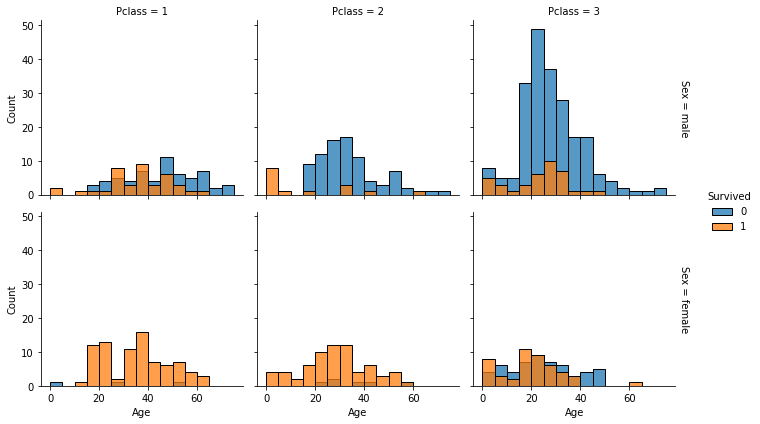

In [30]:
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(df, row='Sex', col='Pclass', hue='Survived', margin_titles=True, height=3, aspect=1.1)
g.map(sns.histplot, 'Age', kde=False, bins=bins)
g.add_legend()
plt.show() 

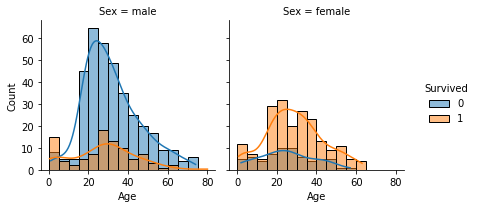

In [32]:
bins = np.arange(0, 80, 5)
g = sns.FacetGrid(df, col='Sex', hue='Survived', margin_titles=True, height=3, aspect=1)
g.map(sns.histplot, 'Age', kde=True, bins=bins)
g.add_legend()
plt.show()

## 名前について

Mr. や Ms.の分布(いわゆる敬称: Honorific Title)

- Mr: 男性

- Miss: 未婚女性

- Mrs: 既婚女性

- Master: 少年、青年

- Dr: 博士

- Rev: 聖職者

- Mlle: 未婚女性(mademoiselleの略らしい)

- Major: 少佐

- Col: 大佐(colonelの略)

- Countless: 伯爵

- Capt: キャプテン

- Ms: 女性

- Sir: 男性

- Lady: 女性

- Mme: マダム(既婚)

- Don: 貴族(男性)

- Jonkheer: 男

Mr, Miss, Mrs, Master 以外は全体の1%以下なので、uncommonなどとしてあげるなどの処理がよいかもしれない。

Mr => 517(58.02%)
Miss => 182(20.43%)
Mrs => 125(14.03%)
Master => 40(4.49%)
Dr => 7(0.79%)
Rev => 6(0.67%)
Col => 2(0.22%)
Major => 2(0.22%)
Mlle => 2(0.22%)
Ms => 1(0.11%)
Mme => 1(0.11%)
Capt => 1(0.11%)
Jonkheer => 1(0.11%)
Don => 1(0.11%)
Countess => 1(0.11%)
Lady => 1(0.11%)
Sir => 1(0.11%)


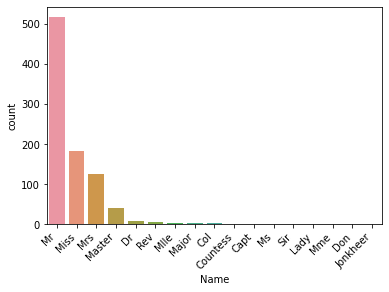

In [8]:
name_title_series = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
unique, count = np.unique(name_title_series, return_counts=True)
sorted_unique_title_idx = np.argsort(-1 * count)
for u, c in zip(unique[sorted_unique_title_idx], count[sorted_unique_title_idx]):
    print(f'{u} => {c}({c / len(name_title_series) * 100:.2f}%)')


chart = sns.countplot(x=name_title_series, order=name_title_series.value_counts().index)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
plt.show()

敬称ごとに年齢の中央値が異なるので、敬称ごとに年齢の中央値を計算して欠損値を埋めるなどの工夫が必要

ex. 
- MissとMrs
- MrとMaster
など

In [9]:
df['Title'] = name_title_series
df.groupby('Title')['Age'].median()

Title
Capt        70.0
Col         58.0
Countess    33.0
Don         40.0
Dr          46.5
Jonkheer    38.0
Lady        48.0
Major       48.5
Master       3.5
Miss        21.0
Mlle        24.0
Mme         24.0
Mr          30.0
Mrs         35.0
Ms          28.0
Rev         46.5
Sir         49.0
Name: Age, dtype: float64

In [10]:
REPLACE2UNCOMMON_TITLE_LIST = ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
MAPPING = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}
df['Title'] = df['Title'].apply(lambda x: x if MAPPING.get(x) is None else MAPPING[x])
df['Title'] = df['Title'].replace(REPLACE2UNCOMMON_TITLE_LIST, 'Uncommon')

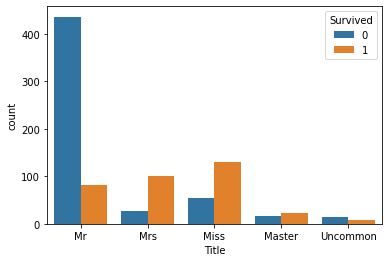

In [118]:
sns.countplot(x='Title', hue='Survived', data=df)
plt.show()

In [17]:
df.groupby('Title')['Age'].mean()

Title
Master       4.574167
Miss        21.845638
Mr          32.368090
Mrs         35.788991
Uncommon    45.545455
Name: Age, dtype: float64